In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage.feature import hog
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [30]:
# Define dataset paths
train_folder = "../dataset/logos_train"
test_folder = "../dataset/logos_test"

# Verify dataset existence
if not os.path.exists(train_folder) or not os.path.exists(test_folder):
    raise FileNotFoundError("Train or test directory not found. Please verify the path.")


In [31]:
# Initialize SIFT feature extractor
sift = cv2.SIFT_create()

# Image processing parameters
image_size = (512, 512)  # Optimized size for memory efficiency
batch_size = 64  # Process 16 images per batch

# Function to extract SIFT features
def extract_sift_features(image):
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((128,))  # Return zero vector if no descriptors
    return np.mean(descriptors, axis=0)  # Use mean of descriptors

# Function to extract HOG features (optimized)
def extract_hog_features(image):
    image = cv2.resize(image, image_size)  # Resize image
    features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
    return features[:500]  # Reduce feature vector to 500 elements

In [32]:
# Function to extract combined SIFT + HOG features
def extract_combined_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, image_size)  # Resize image
    
    # Extract SIFT + HOG features
    sift_features = extract_sift_features(image)
    hog_features = extract_hog_features(image)

    # Concatenate SIFT + HOG features
    combined_features = np.concatenate((sift_features, hog_features))
    return combined_features


In [33]:
# Function to process images in batches
def process_images_in_batches(image_paths):
    features = {}
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i + batch_size]
        for img_path in batch:
            descriptors = extract_combined_features(img_path)
            if descriptors is not None:
                features[img_path] = descriptors
    return features

# Collect training features
train_images = [os.path.join(train_folder, img) for img in os.listdir(train_folder)]
train_features = process_images_in_batches(train_images)

In [34]:
# Convert features to array format
X_train = np.array([desc for desc in train_features.values() if desc is not None])

# ✅ Reduce feature dimensionality with PCA (Optimized)
pca = PCA(n_components=100)  # Reduce to 100 dimensions
X_train_reduced = pca.fit_transform(X_train)

In [35]:
# ✅ Optimize GMM clustering with limited clusters and "diag" covariance
cluster_range = range(2, 11)  # Use a smaller range for efficiency
silhouette_scores = []

for k in cluster_range:
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42, max_iter=200, tol=0.1, reg_covar=0.001, init_params="k-means++")
    labels = gmm.fit_predict(X_train_reduced)
    silhouette_scores.append(silhouette_score(X_train_reduced, labels))

# Determine optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]

# Train GMM with optimal clusters
gmm = GaussianMixture(n_components=optimal_clusters, covariance_type="full", random_state=42, max_iter=200, tol=0.1, reg_covar=0.001, init_params="k-means++")
gmm.fit(X_train_reduced)

GaussianMixture(init_params='k-means++', max_iter=200, n_components=3,
                random_state=42, reg_covar=0.001, tol=0.1)

In [36]:
# Collect test features
test_images = [os.path.join(test_folder, img) for img in os.listdir(test_folder)]
test_features = process_images_in_batches(test_images)

# Convert test features to array format
X_test = np.array([desc for desc in test_features.values() if desc is not None])

# Reduce test feature dimensions using PCA
X_test_reduced = pca.transform(X_test)

# Predict clusters for test images
test_labels = gmm.predict(X_test_reduced)

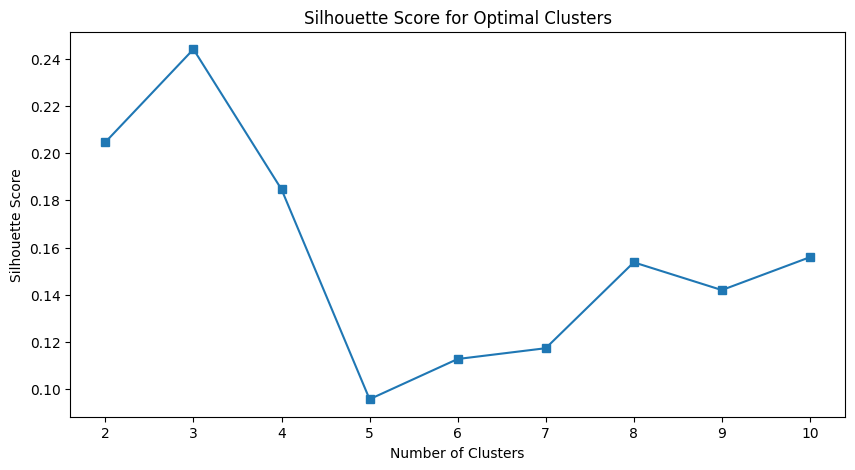

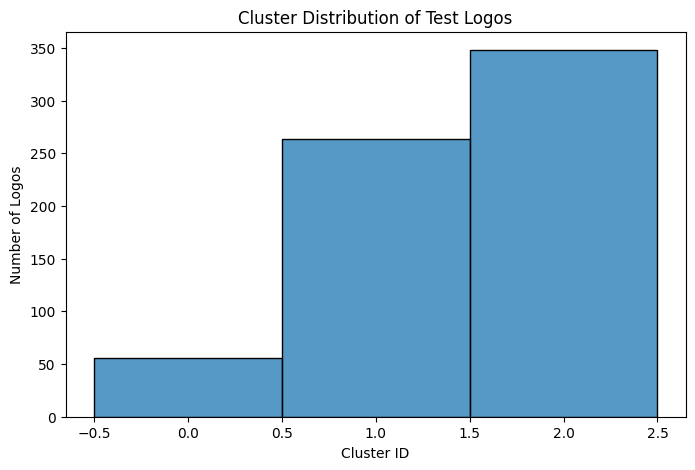

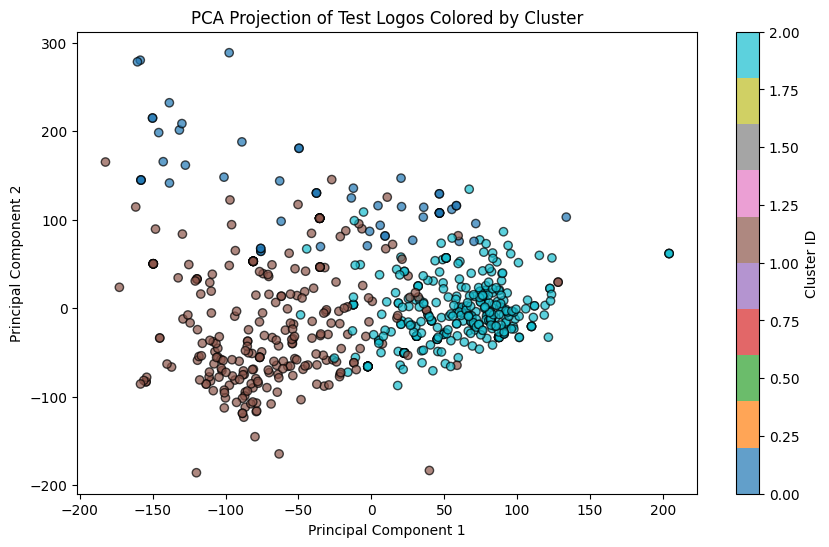

Optimal Number of Clusters: 3
Silhouette Score: 0.24401363832757297


In [37]:

# 📊 Plot Silhouette Score to Find Optimal Clusters
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

# 📊 Cluster Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(test_labels, bins=optimal_clusters, kde=False, discrete=True)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Logos")
plt.title("Cluster Distribution of Test Logos")
plt.show()

# 📊 PCA Projection for 2D Visualization on Test Set
X_test_pca = PCA(n_components=2).fit_transform(X_test_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_labels, cmap="tab10", alpha=0.7, edgecolors="k")
plt.colorbar(label="Cluster ID")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Test Logos Colored by Cluster")
plt.show()

# ✅ Print Results
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Silhouette Score: {silhouette_scores[optimal_clusters-2]}")
